### Drive Mounting

In [1]:
from google.colab import drive
drive.mount('./MyDrive')

Mounted at ./MyDrive


In [2]:
cd MyDrive/My Drive/Colab Notebooks/project

/content/MyDrive/My Drive/Colab Notebooks/project


### Package Loading

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import random_split

from torchvision import transforms
from torchvision.datasets import STL10
from torchsummary import summary

from tqdm.notebook import tqdm
import time

### Parameter Setting

In [7]:
class Config:
    seed = 42
    device = "cuda"if torch.cuda.is_available() else 'cpu'

    student_epochs = 50
    batch_size = 50
    n_classes = 10

    dim_noise = 100
    image_size = (3, 64, 64)

    s_lr = 0.0002
    s_beta1 = 0.5

    d_path = "./checkpoint/pseudo_labels/Discriminator.pt"
    s_path = "./checkpoint/pseudo_labels/Student(Xception).pt"

    student_history_path = "./history/pseudo_labels/student_history(Xception).csv"

print(Config.device)

cuda


In [8]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  
    torch.backends.cudnn.deterministic = True  
    torch.backends.cudnn.benchmark = True 

In [9]:
seed_everything(Config.seed)

### Data Loading

In [10]:
transform = transforms.Compose([transforms.RandomCrop((64, 64)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ])

In [11]:
train_ds = STL10('./data', split='train', download=True, transform=transform)
unlabeled_ds = STL10('./data', split='unlabeled', download=True, transform=transform)
test_ds = STL10('./data', split='test', download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [12]:
train_set, valid_set = random_split(train_ds, [4000, 1000])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


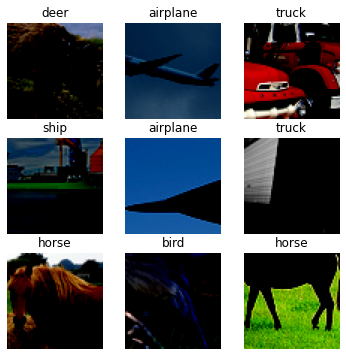

In [13]:
figure = plt.figure(figsize=(6, 6))

classes = ('airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck')
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_set), size=(1,)).item()
    img, label = train_set[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(classes[label])
    plt.axis("off")
    plt.imshow(np.transpose(img, (1, 2, 0)))
plt.show()

In [14]:
print("labeld size: %d" % (len(train_set)))
print("unlabeld size: %d" % (len(unlabeled_ds)))
print("validation size: %d" % (len(valid_set)))
print("test size: %d" % (len(test_ds)))

labeld size: 4000
unlabeld size: 100000
validation size: 1000
test size: 8000


In [15]:
labeled_dl = DataLoader(train_set, batch_size=Config.batch_size, shuffle=True)
unlabeled_dl = DataLoader(unlabeled_ds, batch_size=len(train_set), shuffle=True)
valid_dl = DataLoader(valid_set, batch_size=Config.batch_size,)
test_dl = DataLoader(test_ds, batch_size=Config.batch_size)

### Model Defining

Teacher(DCGAN)

In [16]:
class Discriminator(nn.Module):
    def __init__(self, n_classes):
        super(Discriminator, self).__init__()

        self.layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 10, kernel_size=4, stride=1, padding=0, bias=False),
        )

        self.softmax = nn.Softmax(-1)


        self.initialize_weights()

    def initialize_weights(self):
        for i in self.modules():
          if isinstance(i, nn.Conv2d):
              nn.init.normal_(i.weight, mean=0.0, std=0.02)
          elif isinstance(i, nn.BatchNorm2d):
              nn.init.normal_(i.weight, mean=1.0, std=0.02)
              nn.init.constant_(i.bias, 0)

    def forward(self, inputs):
        x = self.layers(inputs)
        x = x.view(x.shape[0], -1)
        outputs = self.softmax(x)
        return outputs

In [17]:
d_model = Discriminator(n_classes=Config.n_classes).to(Config.device)

summary(d_model, input_size = Config.image_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,072
       BatchNorm2d-2           [-1, 64, 32, 32]             128
         LeakyReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 16, 16]         131,072
       BatchNorm2d-5          [-1, 128, 16, 16]             256
         LeakyReLU-6          [-1, 128, 16, 16]               0
            Conv2d-7            [-1, 256, 8, 8]         524,288
       BatchNorm2d-8            [-1, 256, 8, 8]             512
         LeakyReLU-9            [-1, 256, 8, 8]               0
           Conv2d-10            [-1, 512, 4, 4]       2,097,152
      BatchNorm2d-11            [-1, 512, 4, 4]           1,024
        LeakyReLU-12            [-1, 512, 4, 4]               0
           Conv2d-13             [-1, 10, 1, 1]          81,920
          Softmax-14                   

Student(Xception)

In [18]:
class ConvWithBN(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvWithBN, self).__init__()

        self.layers = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, inputs):
        outputs = self.layers(inputs)

        return outputs

In [19]:
class SeparableConvWithBN(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(SeparableConvWithBN, self).__init__()

        self.layers = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1, groups=in_channels, bias=False),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, inputs):
        outputs = self.layers(inputs)
        
        return outputs

In [20]:
class ShortcutProjectionWithBN(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ShortcutProjectionWithBN, self).__init__()

        self.layers = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2, bias=False),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, inputs):
        outputs = self.layers(inputs)

        return outputs

In [21]:
class EntryFlow(nn.Module):
    def __init__(self):
        super(EntryFlow, self).__init__()

        self.block_1 = nn.Sequential(
            ConvWithBN(3, 32),
            nn.ReLU(),
            ConvWithBN(32, 64),
            nn.ReLU()
        )

        self.block_2 = nn.Sequential(
            SeparableConvWithBN(64, 128),
            nn.ReLU(),
            SeparableConvWithBN(128, 128),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.block_2_shortcut = ShortcutProjectionWithBN(64, 128)

        self.block_3 = nn.Sequential(
            nn.ReLU(),
            SeparableConvWithBN(128, 256),
            nn.ReLU(),
            SeparableConvWithBN(256, 256),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.block_3_shortcut = ShortcutProjectionWithBN(128, 256)

        self.block_4 = nn.Sequential(
            nn.ReLU(),
            SeparableConvWithBN(256, 728),
            nn.ReLU(),
            SeparableConvWithBN(728, 728),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.block_4_shortcut = ShortcutProjectionWithBN(256, 728)

    def forward(self, inputs):
        x = self.block_1(inputs)
        x = self.block_2(x) + self.block_2_shortcut(x)
        x = self.block_3(x) + self.block_3_shortcut(x)
        outputs = self.block_4(x) + self.block_4_shortcut(x)
        
        return outputs

In [22]:
class MiddleFlow(nn.Module):
    def __init__(self):
        super().__init__()

        self.layers = nn.Sequential(
            nn.ReLU(),
            SeparableConvWithBN(728, 728),
            nn.ReLU(),
            SeparableConvWithBN(728, 728),
            nn.ReLU(),
            SeparableConvWithBN(728, 728),
        )

    def forward(self, inputs):
        outputs = self.layers(inputs) + inputs

        return outputs

In [23]:
class ExitFlow(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        self.block_1 = nn.Sequential(
            nn.ReLU(),
            SeparableConvWithBN(728, 728),
            nn.ReLU(),
            SeparableConvWithBN(728, 1024),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.block_1_shortcut = ShortcutProjectionWithBN(728, 1024)

        self.block_2 = nn.Sequential(
            SeparableConvWithBN(1024, 1536),
            nn.ReLU(),
            SeparableConvWithBN(1536, 2048),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size = 4, stride = 1),
        )
    
    def forward(self, inputs):
        x = self.block_1(inputs) + self.block_1_shortcut(inputs)
        outputs = self.block_2(x)

        return outputs

In [24]:
class Xception(nn.Module):
    def __init__(self, n_classes):
        super(Xception, self).__init__()

        self.entry_flow = EntryFlow()
        self.middle_flow = self.make_middle_flow()
        self.exit_flow = ExitFlow() 

        self.classifier = nn.Sequential(
          nn.Dropout(p=0.5),
          nn.Linear(2048, n_classes)
        )

        self.initialize_weights()

    def make_middle_flow(self):
        outputs = []

        for i in range(8):
            outputs.append(MiddleFlow())

        return nn.Sequential(*outputs)

    def initialize_weights(self):
      for i in self.modules():
        if isinstance(i, nn.Conv2d):
            nn.init.kaiming_normal_(i.weight, mode='fan_in', nonlinearity='relu')
        elif isinstance(i, nn.Linear):
            nn.init.kaiming_normal_(i.weight, mode='fan_in', nonlinearity='relu')
            nn.init.constant_(i.bias, 0)

    def forward(self, inputs):
      x = self.entry_flow(inputs)
      x = self.middle_flow(x)
      x = self.exit_flow(x)
      x = x.view(x.shape[0], -1)
      outputs = self.classifier(x)
        
      return outputs

In [25]:
s_model = Xception(n_classes=Config.n_classes).to(Config.device)

summary(s_model, input_size = (Config.image_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             864
       BatchNorm2d-2           [-1, 32, 64, 64]              64
        ConvWithBN-3           [-1, 32, 64, 64]               0
              ReLU-4           [-1, 32, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          18,432
       BatchNorm2d-6           [-1, 64, 64, 64]             128
        ConvWithBN-7           [-1, 64, 64, 64]               0
              ReLU-8           [-1, 64, 64, 64]               0
            Conv2d-9           [-1, 64, 64, 64]             576
           Conv2d-10          [-1, 128, 64, 64]           8,192
      BatchNorm2d-11          [-1, 128, 64, 64]             256
SeparableConvWithBN-12          [-1, 128, 64, 64]               0
             ReLU-13          [-1, 128, 64, 64]               0
           Conv2d-14          [-1, 12

### Training Setting

In [26]:
cross_entropy = nn.CrossEntropyLoss(reduction='mean')

s_optimizer = optim.Adam(s_model.parameters(), lr=Config.s_lr, betas=(Config.s_beta1, 0.999))

In [27]:
def student_training(d_model, s_model, s_optimizer, epochs, s_path, history_path, labeled_dl, unlabeled_dl, valid_dl):
    history = {'S_loss':[], 'S_valid_acc':[]}        
    start_time = time.time()

    current_label_epoch = 0;
    
    d_model.eval()
    for unlabel_iter in range(int(epochs/len(unlabeled_dl))): 
        for unlabeled_batch, _ in unlabeled_dl:
            epoch_time = time.time()

            total_S_loss = 0

            s_model.train()
            for (labeled_inputs, labels), i in tqdm(zip(labeled_dl, range(len(labeled_dl))), total=len(labeled_dl), desc="Training", leave=False):
                labeled_inputs, labels = labeled_inputs.to(Config.device), labels.to(Config.device)
                unlabeled_inputs = unlabeled_batch[i*Config.batch_size:(i+1)*Config.batch_size].to(Config.device)

                d_unlabeled_outputs = d_model(unlabeled_inputs)
                _, pseudo_labels = torch.max(d_unlabeled_outputs.detach().data, 1)

                s_optimizer.zero_grad()

                s_unlabeled_outputs = s_model(unlabeled_inputs)
                s_labeled_outputs = s_model(labeled_inputs)

                s_cross_entropy_unlabeled = cross_entropy(s_unlabeled_outputs, pseudo_labels)
                s_cross_entropy_labeled = cross_entropy(s_labeled_outputs, labels)

                s_loss = s_cross_entropy_unlabeled + s_cross_entropy_labeled
                s_loss.backward(retain_graph=True)
                s_optimizer.step()

                total_S_loss += s_loss.item()

            S_loss = total_S_loss / len(labeled_dl)

            history['S_loss'].append(S_loss)

            valid_total = 0
            valid_correct = 0

            s_model.eval()
            with torch.no_grad():
              for inputs, labels in tqdm(valid_dl, desc="Validation", leave=False):
                  inputs, labels = inputs.to(Config.device), labels.to(Config.device)
                  outputs = s_model(inputs)
                  _, predicted = torch.max(outputs.data, 1)

                  valid_total += labels.size(0)
                  valid_correct += (predicted == labels).sum().item()

            valid_acc = valid_correct / valid_total * 100

            history['S_valid_acc'].append(valid_acc)

            current_label_epoch += 1
            tqdm.write('[Epoch : %d/%d] S_loss: %.5f, S_valid_acc: %.2f, elapsed_time_in_epoch: %02d:%02d' % (current_label_epoch, epochs, S_loss, valid_acc, (time.time()-epoch_time)/60, (time.time()-epoch_time)%60))

            torch.save(s_model.state_dict(), s_path)

    print('Finished training')
    print('Total elapsed time: %02d:%02d' % ((time.time()-start_time)/60, (time.time()-start_time)%60))

    history_df = pd.DataFrame(history)
    history_df.to_csv(history_path)

    return s_model, history

### Training Student with Pseudo Labels

In [28]:
d_model.load_state_dict(torch.load(Config.d_path))

<All keys matched successfully>

In [29]:
s_model, student_history = student_training(d_model, s_model, s_optimizer, Config.student_epochs, Config.s_path, Config.student_history_path, labeled_dl, unlabeled_dl, valid_dl)

Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 1/50] S_loss: 3.87653, S_valid_acc: 38.10, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 2/50] S_loss: 3.20093, S_valid_acc: 41.30, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 3/50] S_loss: 2.96657, S_valid_acc: 41.80, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 4/50] S_loss: 2.81171, S_valid_acc: 46.90, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 5/50] S_loss: 2.64351, S_valid_acc: 42.30, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 6/50] S_loss: 2.48756, S_valid_acc: 55.00, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 7/50] S_loss: 2.44214, S_valid_acc: 52.30, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 8/50] S_loss: 2.30111, S_valid_acc: 52.80, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 9/50] S_loss: 2.25880, S_valid_acc: 48.20, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 10/50] S_loss: 2.18942, S_valid_acc: 54.90, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 11/50] S_loss: 2.14635, S_valid_acc: 59.20, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 12/50] S_loss: 2.06319, S_valid_acc: 51.20, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 13/50] S_loss: 2.03458, S_valid_acc: 57.00, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 14/50] S_loss: 1.97231, S_valid_acc: 58.60, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 15/50] S_loss: 1.93224, S_valid_acc: 54.30, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 16/50] S_loss: 1.90438, S_valid_acc: 53.00, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 17/50] S_loss: 1.85765, S_valid_acc: 58.20, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 18/50] S_loss: 1.81408, S_valid_acc: 56.60, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 19/50] S_loss: 1.79888, S_valid_acc: 58.00, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 20/50] S_loss: 1.73871, S_valid_acc: 59.60, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 21/50] S_loss: 1.70298, S_valid_acc: 58.00, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 22/50] S_loss: 1.67707, S_valid_acc: 58.80, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 23/50] S_loss: 1.62597, S_valid_acc: 58.40, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 24/50] S_loss: 1.60419, S_valid_acc: 58.30, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 25/50] S_loss: 1.60559, S_valid_acc: 62.50, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 26/50] S_loss: 1.58033, S_valid_acc: 60.80, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 27/50] S_loss: 1.56933, S_valid_acc: 62.40, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 28/50] S_loss: 1.55851, S_valid_acc: 61.00, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 29/50] S_loss: 1.53379, S_valid_acc: 61.80, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 30/50] S_loss: 1.49428, S_valid_acc: 59.80, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 31/50] S_loss: 1.47459, S_valid_acc: 64.10, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 32/50] S_loss: 1.44880, S_valid_acc: 62.10, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 33/50] S_loss: 1.45398, S_valid_acc: 63.10, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 34/50] S_loss: 1.43243, S_valid_acc: 63.90, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 35/50] S_loss: 1.37691, S_valid_acc: 63.50, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 36/50] S_loss: 1.36288, S_valid_acc: 62.00, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 37/50] S_loss: 1.35103, S_valid_acc: 61.40, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 38/50] S_loss: 1.34200, S_valid_acc: 61.40, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 39/50] S_loss: 1.31757, S_valid_acc: 64.10, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 40/50] S_loss: 1.29364, S_valid_acc: 61.20, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 41/50] S_loss: 1.33771, S_valid_acc: 61.80, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 42/50] S_loss: 1.27669, S_valid_acc: 63.40, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 43/50] S_loss: 1.25650, S_valid_acc: 64.60, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 44/50] S_loss: 1.26326, S_valid_acc: 66.10, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 45/50] S_loss: 1.26582, S_valid_acc: 62.70, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 46/50] S_loss: 1.17911, S_valid_acc: 65.80, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 47/50] S_loss: 1.21506, S_valid_acc: 64.20, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 48/50] S_loss: 1.18566, S_valid_acc: 65.40, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 49/50] S_loss: 1.19860, S_valid_acc: 63.80, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 50/50] S_loss: 1.21024, S_valid_acc: 63.90, elapsed_time_in_epoch: 00:28
Finished training
Total elapsed time: 25:29


### Testing

In [30]:
s_model.load_state_dict(torch.load(Config.s_path))

test_total = 0
test_correct = 0

s_model.eval()
with torch.no_grad():
    for inputs, labels in test_dl:
        inputs, labels = inputs.to(Config.device), labels.to(Config.device)
        outputs = s_model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_acc = test_correct / test_total * 100
print("s_model test_acc: %.5f" %(test_acc))

s_model test_acc: 63.75000
